### Análise de sentimentos do Twitter
#### Dataset from Kaggle: 
https://www.kaggle.com/arkhoshghalb/twitter-sentiment-analysis-hatred-speech 

#### Contexto: 
O objetivo desta tarefa é detectar a incitação ao ódio nos tweets. Para simplificar, dizemos que um tweet contém discurso de ódio se tiver um sentimento racista ou sexista associado a ele. Portanto, a tarefa é classificar tweets racistas ou sexistas de outros tweets. Formalmente, dada uma amostra de treinamento de tweets e labels, em que o label '1' indica que o tweet é racista/sexista e o label '0' indica que o tweet não é racista/sexista, seu objetivo é prever os rótulos no conjunto de dados de teste.

1. Importando dependências

In [1]:
import re
import nltk  
from nltk.tokenize import TweetTokenizer
from nltk.stem.porter import * 
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

2. Importando os dados

In [2]:
train = pd.read_csv('train_twitter.csv')
test = pd.read_csv('test_twitter.csv')

3. Explorando os dados

3.1. Verificando os dados de treino e teste

In [3]:
# label 0 = não racista/sexista
train[train['label'] == 0].head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0,factsguide: society now #motivation


In [4]:
# label 1 = racista/sexista
train[train['label'] == 1].head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot
14,15,1,no comment! in #australia #opkillingbay #seashepherd #helpcovedolphins #thecove #helpcovedolphins
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'd need something like this. again. #neverump #xenophobia


In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,31964,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,31965,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,31966,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,31967,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"


3.2. Sobre os dados

In [6]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [7]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

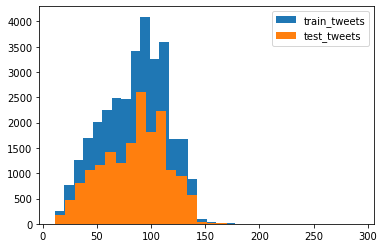

In [8]:
length_train = train['tweet'].str.len() 
length_test = test['tweet'].str.len() 

plt.hist(length_train, bins=30, label="train_tweets") 
plt.hist(length_test, bins=30, label="test_tweets") 
plt.legend() 
plt.show()

In [9]:
train.isnull().sum(), test.isnull().sum()

(id       0
 label    0
 tweet    0
 dtype: int64,
 id       0
 tweet    0
 dtype: int64)

4. Limpeza dos dados

In [10]:
# antes de iniciar a limpeza, agrupo os dados de treino e teste
group_data = train.append(test, ignore_index=True) 
group_data.shape

(49159, 3)

In [11]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt  

4.1. Removendo Twitter Handles (@user)

In [12]:
group_data['tidy_tweet'] = np.vectorize(remove_pattern)(group_data['tweet'], "@[\w]*") 
group_data.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,5,0.0,factsguide: society now #motivation,factsguide: society now #motivation


4.2. Removendo pontuações, números e caracteres especiais

In [13]:
group_data['tidy_tweet'] = group_data['tidy_tweet'].str.replace("[^a-zA-Z#]", " ") 
group_data.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when a father is dysfunctional and is so selfish he drags his kids into his dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks for #lyft credit i can t use cause they don t offer wheelchair vans in pdx #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model i love u take with u all the time in ur
4,5,0.0,factsguide: society now #motivation,factsguide society now #motivation


4.3. Removendo short words, palavras com menos de 3 letras

In [14]:
group_data['tidy_tweet'] = group_data['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
group_data.head()

,id,label,tweet,tidy_tweet
0,1,0.0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,when father dysfunctional selfish drags kids into dysfunction #run
1,2,0.0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks #lyft credit cause they offer wheelchair vans #disapointed #getthanked
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


4.4. Normalização do texto

In [15]:
tokenized_tweet = group_data['tidy_tweet'].apply(lambda x: x.split()) 
tokenized_tweet.head()

0                [when, father, dysfunctional, selfish, drags, kids, into, dysfunction, #run]
1    [thanks, #lyft, credit, cause, they, offer, wheelchair, vans, #disapointed, #getthanked]
2                                                                     [bihday, your, majesty]
3                                                            [#model, love, take, with, time]
4                                                          [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [16]:
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [17]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])    
group_data['tidy_tweet'] = tokenized_tweet

5. Storytelling e visualização dos tweets

5.1. WordCloud: entendo as palavras comuns usadas nos tweets

- Tweets não racistas/sexistas

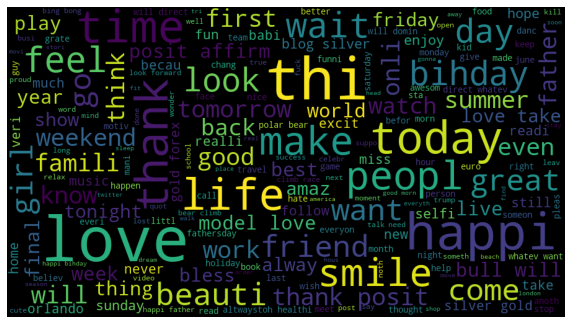

In [18]:
normal_words =' '.join([text for text in group_data['tidy_tweet'][group_data['label'] == 0]]) 
wordcloud = WordCloud(width=900, height=500, random_state=21, max_font_size=100).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- Tweets racistas/sexistas

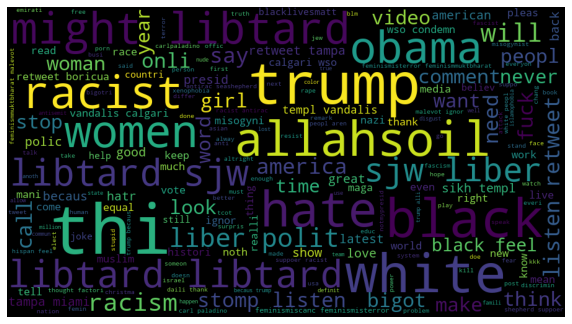

In [19]:
negative_words = ' '.join([text for text in group_data['tidy_tweet'][group_data['label'] == 1]])
wordcloud = WordCloud(width=900, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

5.2. Impacto das hashtags na análise de sentimento dos tweets

In [20]:
def hashtag_extract(x):
    hashtags = []  
  
    for i in x:        
        ht = re.findall(r"#(\w+)", i)        
        hashtags.append(ht)     
    return hashtags


# tweets não racistas/sexistas 
HT_normal = hashtag_extract(group_data['tidy_tweet'][group_data['label'] == 0])
# tweets racistas/sexistas
HT_negative = hashtag_extract(group_data['tidy_tweet'][group_data['label'] == 1])


HT_normal = sum(HT_normal,[])
HT_negative = sum(HT_negative,[])

- Tweets não racistas/sexistas

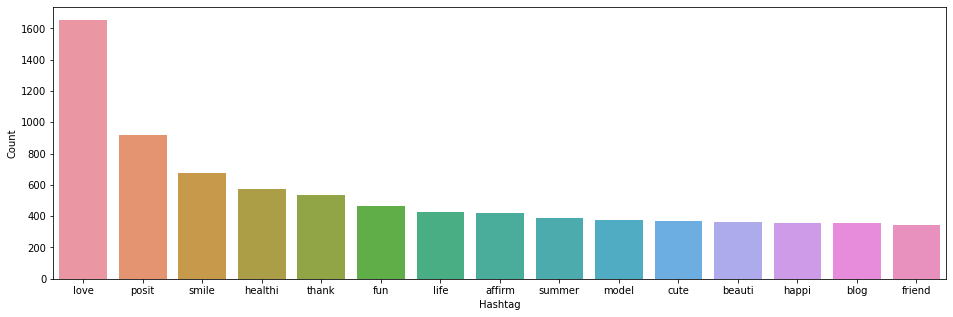

In [21]:
a = nltk.FreqDist(HT_normal)
d = pd.DataFrame({'Hashtag': list(a.keys()),'Count': list(a.values())}) 

# TOP 15 hashtags     
d = d.nlargest(columns="Count", n = 15) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=d, x= "Hashtag", y = "Count") 
ax.set(ylabel = 'Count') 
plt.show()

- Tweets racistas/sexistas

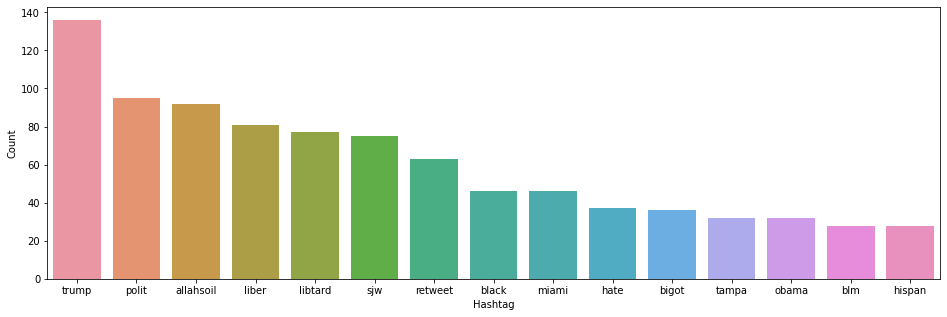

In [22]:
b = nltk.FreqDist(HT_negative) 
e = pd.DataFrame({'Hashtag': list(b.keys()),'Count': list(b.values())}) 

# TOP 15 hashtags 
e = e.nlargest(columns="Count", n = 15)   
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")

6. TF-IDF Features

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(group_data['tidy_tweet'])
tfidf.shape

(49159, 1000)

In [24]:
pd.DataFrame(tfidf.toarray(), columns = tfidf_vectorizer.get_feature_names())

,abl,absolut,accept,account,act,action,activ,actor,actual,adapt,...,yay,yeah,year,yesterday,yoga,york,young,youth,youtub,yummi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


7. Modelos

In [25]:
train_tfidf = tfidf[:31962,:] 
test_tfidf = tfidf[31962:,:] 

xtrain_tfidf, xvalid_tfidf, ytrain, yvalid = train_test_split(train_tfidf, train['label'],
                                                              random_state=42,
                                                              test_size=0.3)

7.1. Logistic Regression

In [26]:
lreg = LogisticRegression()
lreg.fit(xtrain_tfidf, ytrain) 
prediction = lreg.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
print("F1 score:", f1_score(yvalid, prediction_int))
print("Acurácia:", accuracy_score(yvalid, prediction_int)) 

F1 score: 0.5451327433628319
Acurácia: 0.9463969131296277


7.2. Support Vector Machine (SVM)

In [27]:
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain) 
prediction = svc.predict_proba(xvalid_tfidf) 
prediction_int = prediction[:,1] >= 0.3 
prediction_int = prediction_int.astype(np.int) 
print("F1 score:", f1_score(yvalid, prediction_int))
print("Acurácia:", accuracy_score(yvalid, prediction_int)) 

F1 score: 0.5104831358249772
Acurácia: 0.9439983314214204


7.3. RandomForest

In [28]:
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain) 
prediction_rf = rf.predict(xvalid_tfidf) 
f1_score(yvalid, prediction_rf)
print("F1 score:", f1_score(yvalid, prediction_rf))
print("Acurácia:", accuracy_score(yvalid, prediction_rf))

F1 score: 0.562152133580705
Acurácia: 0.9507769319011368


In [29]:
test_pred = rf.predict(test_tfidf)
test['label'] = test_pred 
submission = test[['id','label','tweet']]
submission.to_csv('sub_rf_tfidf.csv', index=False)